## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = False
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace = False),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
       BatchNorm1d-3                  [-1, 400]             800
              ReLU-4                  [-1, 400]               0
            Linear-5                  [-1, 200]          80,200
              ReLU-6                  [-1, 200]               0
           Dropout-7                  [-1, 200]               0
            Linear-8                  [-1, 100]          20,100
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
Total params: 416,110
Trainable params: 416,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.59
Estimated T

Your experiments come here:

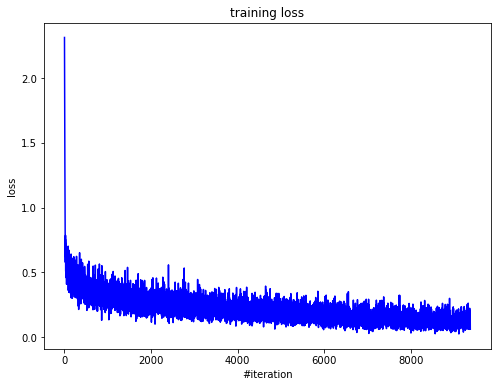

current loss: 0.060682


In [9]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
n_epoch = 20
loss_history = []

for epoch in range(n_epoch):
    for x_train, y_train in train_loader:
        opt.zero_grad()
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        model.forward(x_train)
        loss_value = loss_func(model(x_train), y_train)
        loss_history.append(loss_value)
        loss_value.backward()
        opt.step()

    clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title('training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('current loss: %f' % loss_value)

In [10]:
from sklearn.metrics import accuracy_score

def evaluate_accuracy(model):
    model.eval()
    accuracy_history = []
    for X_test, Y_test in test_loader:    
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        predictions = model.forward(X_test)
        accuracy = accuracy_score(predictions.argmax(axis=1), Y_test)
        accuracy_history.append(accuracy)
    return np.mean(accuracy_history)
    
print('accuracy score:', evaluate_accuracy(model))

accuracy score: 0.89140625


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [11]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [12]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 64]          16,448
         LeakyReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
         LeakyReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
       LogSoftmax-11                   [-1, 10]               0
Total params: 552,106
Trainable params: 552,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [13]:
def plot(first, second, title, ylabel):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("#epoch")
    plt.ylabel(ylabel)
    plt.grid()
    plt.plot(first, 'b', label = 'train')
    plt.plot(second, 'g', label = 'test')
    plt.legend()
    plt.show()

In [14]:
def train_loop(net, n_epoch):
    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for i in range(n_epoch):
        train_loss_epoch = []
        train_accuracy_epoch = []
        
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = net.forward(x_batch)
            loss = criterion(predictions, y_batch)
            
            test_accuracy = accuracy_score(predictions.argmax(axis=1), y_batch)
            train_accuracy_epoch.append(test_accuracy)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss_epoch.append(loss.detach().numpy())

        train_loss_history.append(np.mean(train_loss_epoch))
        train_accuracy_history.append(np.mean(train_accuracy_epoch))
        
        net.eval()
        test_accuracy_epoch=[]
        test_loss_epoch=[]
        with torch.no_grad():    
            for X_val, Y_val in test_loader:    
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                val_predictions = net.forward(X_val)
                val_loss = criterion(val_predictions, Y_val)
                test_loss_epoch.append(val_loss)
                val_acc = accuracy_score(val_predictions.argmax(axis=1), Y_val)
                test_accuracy_epoch.append(val_acc)
                
        net.train()
        
        test_loss_history.append(np.mean(test_loss_epoch))
        test_accuracy_history.append(np.mean(test_accuracy_epoch))
        
    return train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history

In [15]:
model = OverfittingNeuralNetwork().to(device)
n_epoch = 40

train_loss, test_loss, train_accuracy, test_accuracy = train_loop(model, n_epoch=n_epoch)


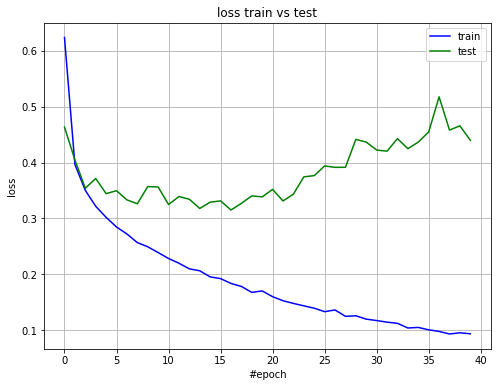

In [16]:
plot(train_loss, test_loss, "loss train vs test", "loss")

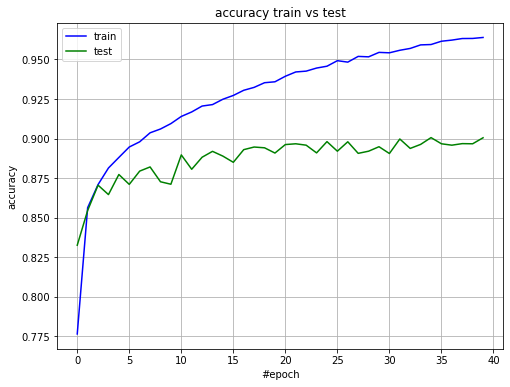

In [17]:
plot(train_accuracy, test_accuracy, "accuracy train vs test", "accuracy")

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [19]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64),
            nn.Dropout(0.4),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [20]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Dropout-3                  [-1, 512]               0
         LeakyReLU-4                  [-1, 512]               0
       BatchNorm1d-5                  [-1, 512]           1,024
            Linear-6                  [-1, 256]         131,328
         LeakyReLU-7                  [-1, 256]               0
       BatchNorm1d-8                  [-1, 256]             512
            Linear-9                   [-1, 64]          16,448
          Dropout-10                   [-1, 64]               0
        LeakyReLU-11                   [-1, 64]               0
      BatchNorm1d-12                   [-1, 64]             128
           Linear-13                   [-1, 32]           2,080
        LeakyReLU-14                   

In [21]:
model = FixedNeuralNetwork().to(device)
n_epoch = 40

train_loss, test_loss, train_accuracy, test_accuracy = train_loop(model, n_epoch=n_epoch)

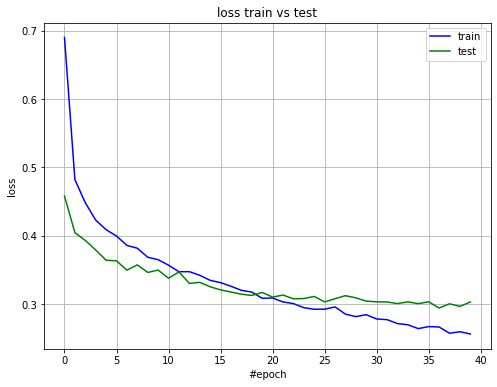

In [22]:
plot(train_loss, test_loss, "loss train vs test", "loss")

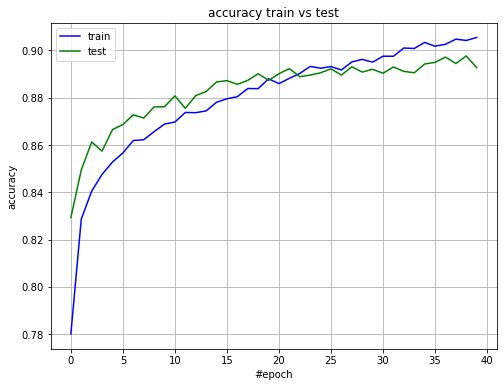

In [23]:
plot(train_accuracy, test_accuracy, "accuracy train vs test", "accuracy")

In [24]:
print('accuracy score:', evaluate_accuracy(model))

accuracy score: 0.89267578125


### Conclusions:
_Write down small report with your conclusions and your ideas._

In the first task we have created small net with simple architecture. Then we tried to create bigger net for better accuracy, but it tend to overfit. In the third task we tried to use regularization techniques (batchnorm with dropout) and it showed us a good result. From figures, it is easy to see that this techniques helped us a lot to fight against overfitting. I guess we could use even longer training process for better accuracy, but i don't have gpu for it.